In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import pandas as pd
import numpy as np
import math

!pip install leidenalg python-igraph

# graph related library
import networkx as nx
import leidenalg
import igraph as ig
import community as community_louvain
import networkx.algorithms.community as nx_comm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 66.7 MB/s eta 0:00:00


In [ ]:
cora = pd.read_csv('cora.cites',
                   sep='\t', header=None,
                   names=['node1', 'node2'])

# Create graph from edge list
cora_network = nx.Graph(cora.values.tolist())

# Get graph info
print("Cora Network Info:")
print("Number of nodes:", cora_network.number_of_nodes())
print("Number of edges:", cora_network.number_of_edges())
print("Average Cluster Coefficients:", nx.average_clustering(cora_network))
print("Connected components:", len(list(nx.connected_components(cora_network))))

Cora Network Info:
Number of nodes: 2708
Number of edges: 5278
Average Cluster Coefficients: 0.2406732985019372
Connected components: 78


Overall, the probability of adjacent nodes being connected is 24.06%.

### 1. Louvain Algorithm for Community Detection

In [ ]:
#%%time

louvain_communities = community_louvain.best_partition(cora_network, random_state=0)

In [ ]:
# convert community dictionary to a list of community node lists
# made for Louvain output
def convert_communities_dict_to_list(communities_dict):
    unique_partition_count = len(list(set(communities_dict.values())))
    print("Number of unique communities:", unique_partition_count)
    communities = [[] for i in range(unique_partition_count)]
    for node in communities_dict.keys():
        communities[communities_dict[node]].append(node)
    return communities

In [ ]:
louvain_communities = convert_communities_dict_to_list(louvain_communities)

Number of unique communities: 104


In [ ]:
louvain_communities

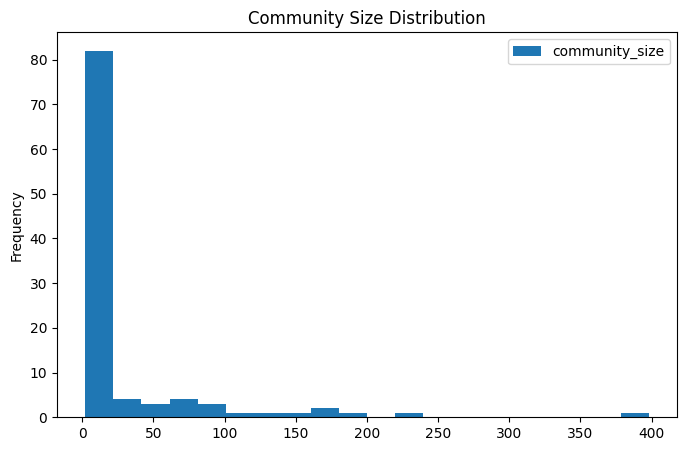

In [ ]:
community_sizes = pd.DataFrame([len(community) for community in louvain_communities],
                               columns=["community_size"])
community_sizes.plot.hist(bins=20, figsize=(8,5), title="Community Size Distribution");

In [ ]:
%%time

# take a look at the modularity of the Louvain algorithm output
print("Modularity:",
      round(nx_comm.modularity(cora_network, louvain_communities), 6))

Modularity: 0.813273
CPU times: user 13.3 ms, sys: 1.81 ms, total: 15.1 ms
Wall time: 15.3 ms


In [ ]:
# function to check whether the determined communities are connected
def check_community_disconnection(graph, communities):
    total_connected = 0
    disconnected_community_indexes = []
    for i in range(len(communities)):
        if nx.is_connected(graph.subgraph(communities[i])):
            total_connected += 1
        else:
            disconnected_community_indexes.append(i)
    print("Total Communities:", len(communities))
    print("Total Communities Connected:", total_connected)
    print("Disconnected Community Indexes:", disconnected_community_indexes)

In [ ]:
%%time

check_community_disconnection(cora_network, louvain_communities)

Total Communities: 104
Total Communities Connected: 104
Disconnected Community Indexes: []
CPU times: user 28.5 ms, sys: 0 ns, total: 28.5 ms
Wall time: 60.5 ms


In [ ]:
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    colors = ["#EF9A9A", "#BA68C8", "#64B5F6", "#81C784",
              "#FFF176", "#BDBDBD"][:number_of_colors]
    node_colors = []

    # iterate each node in the graph and find which community it belongs to
    # if the current node is found at a specific community, add color to the
    # node_colors list
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors

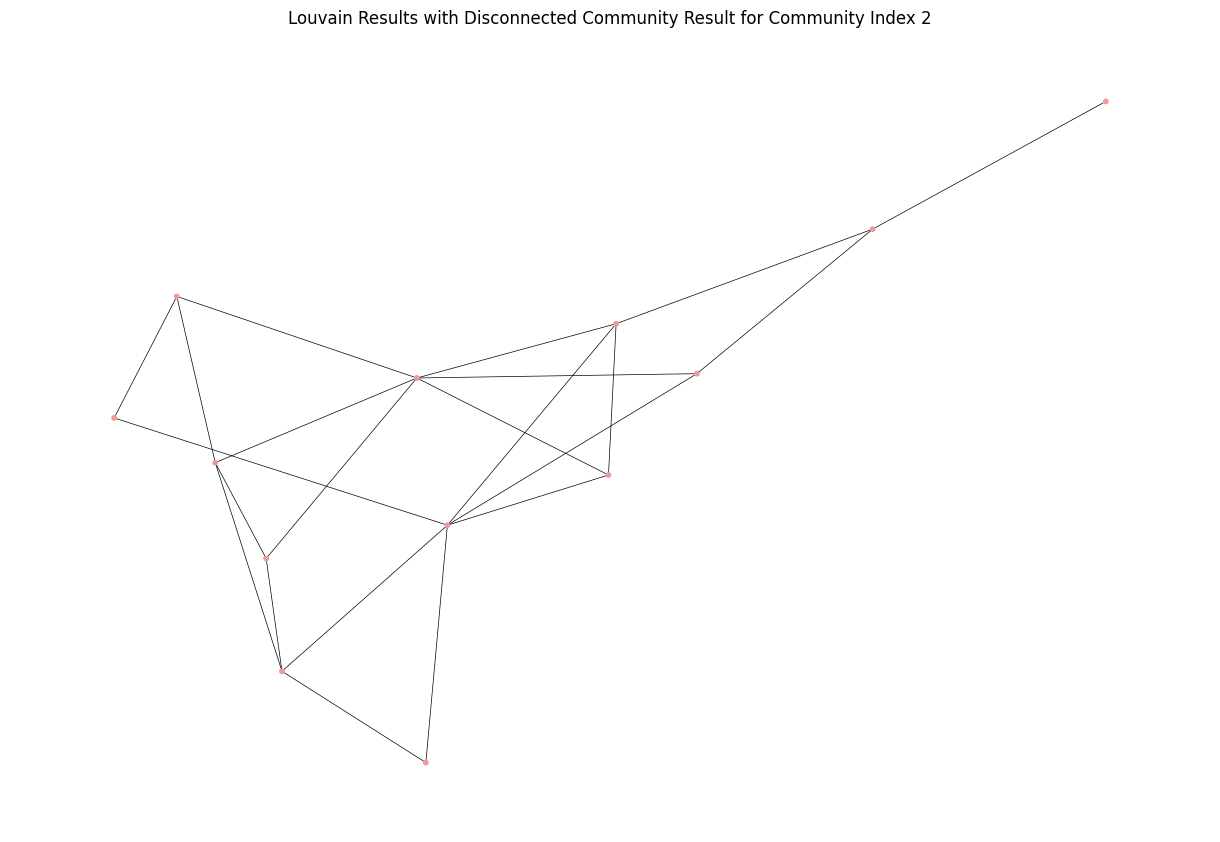

In [ ]:
# get subgraph of community with index 131 for demo
disconnected_subgraph = cora_network.subgraph(louvain_communities[2])
disconnected_components = list(nx.connected_components(disconnected_subgraph))

# create visualization
node_colors = create_community_node_colors(disconnected_subgraph, disconnected_components)
pos = nx.spring_layout(disconnected_subgraph, iterations=50, k=0.05,
                       seed=2)

plt.figure(1,figsize=(12,8))
nx.draw(disconnected_subgraph,
        pos = pos,
        node_size=10,
        width=0.5,
        node_color=node_colors)
plt.title("Louvain Results with Disconnected Community Result for Community Index 2")
plt.show()

### DBLP collaboration network and ground-truth communities

The DBLP computer science bibliography provides a comprehensive list of research papers in computer science. We construct a co-authorship network where two authors are connected if they publish at least one paper together. Publication venue, e.g, journal or conference, defines an individual ground-truth community; authors who published to a certain journal or conference form a community.

#### Please download the dataset first.
Because the data is ~13 MB. You can download it from the link below and put it in the root directory of this project folder to run the code below.
Dataset download link: https://snap.stanford.edu/data/com-DBLP.html

In [ ]:
DBLP = pd.read_csv('com-dblp.ungraph.txt',
                   sep='\t', header=None, skiprows = 4,
                   names=['node1', 'node2'])